In [52]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time
import os
import numpy as np
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib
#%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm 

import torchaudio
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataset import random_split

'''
The file depth must be same
put the path where Sub-URMP folder in Dataset_path variable. 
'''
# Dataset_Path = 'C:/Users/VML/ML_final/' # + Sub-URMP/chunk/train # Gihoon
Dataset_Path = 'C:/Users/User/GCT634 Final/' # Jiho

# Data Check

In [2]:
def CheckDataset(path=None, train=False, filetype=None):
    print("############################################")
    if train==True:
        print("Train ("+filetype+")")
    else:
        print("Test ("+filetype+")")
    list = os.listdir(path)
    Total=0
    for i in list:
        temp = os.listdir(os.path.join(path,i))
        print(i+": "+str(len(temp)))
        Total += len(temp)
    print("Total: ", Total)    
    print("############################################")    

In [3]:
CheckDataset(Dataset_Path + r"Sub-URMP\img\train", True, 'img')

############################################
Train (img)
bassoon: 1735
cello: 9800
clarinet: 8125
double_bass: 1270
flute: 5690
horn: 5540
oboe: 4505
sax: 7615
trombone: 8690
trumpet: 1015
tuba: 3285
viola: 6530
violin: 7430
Total:  71230
############################################


In [4]:
CheckDataset(Dataset_Path + r"Sub-URMP\chunk\train", True, 'wav')

############################################
Train (wav)
bassoon: 1735
cello: 9800
clarinet: 8125
double_bass: 1270
flute: 5690
horn: 5540
oboe: 4505
sax: 7615
trombone: 8690
trumpet: 1015
tuba: 3285
viola: 6530
violin: 7430
Total:  71230
############################################


In [5]:
CheckDataset(Dataset_Path + r"Sub-URMP\img\test", False, 'img')

############################################
Test (img)
bassoon: 390
cello: 1030
clarinet: 945
double_bass: 1180
flute: 925
horn: 525
oboe: 390
sax: 910
trombone: 805
trumpet: 520
tuba: 525
viola: 485
violin: 945
Total:  9575
############################################


In [6]:
CheckDataset(Dataset_Path + r"Sub-URMP\chunk\test", False, 'wav')

############################################
Test (wav)
bassoon: 390
cello: 1030
clarinet: 945
double_bass: 1180
flute: 925
horn: 525
oboe: 390
sax: 910
trombone: 805
trumpet: 520
tuba: 525
viola: 485
violin: 945
Total:  9575
############################################


# Change File name

In [7]:
def ChangeFileName(path, filetype):
    j = os.listdir(path)
    for instrumentclass in j:
        idx = 1
        i = os.listdir(os.path.join(path,instrumentclass))
        renamepath = os.path.join(path,instrumentclass)
        for eachdata in i:
            #print(os.path.join(renamepath, eachdata))
            os.rename(os.path.join(renamepath, eachdata), os.path.join(renamepath, str(idx)+'.'+filetype))
            idx += 1

In [8]:
# GCT634 Final --> your directory name
'''
ChangeFileName(Dataset_Path + r"Sub-URMP\chunk\train", 'wav')
ChangeFileName(Dataset_Path + r"Sub-URMP\chunk\test", 'wav')
ChangeFileName(Dataset_Path + r"Sub-URMP\img\train", 'jpg')
ChangeFileName(Dataset_Path + r"Sub-URMP\img\test", 'jpg')
'''

'\nChangeFileName(Dataset_Path + r"Sub-URMP\\chunk\train", \'wav\')\nChangeFileName(Dataset_Path + r"Sub-URMP\\chunk\test", \'wav\')\nChangeFileName(Dataset_Path + r"Sub-URMP\\img\train", \'jpg\')\nChangeFileName(Dataset_Path + r"Sub-URMP\\img\test", \'jpg\')\n'

# Dataset and DataLoader

In [9]:
class SubURMP(Dataset):
    """Customized SubURMP Dataset.
    datset
        `-- SubURMP
            |-- img
                |-- train
                    |-- bassoon
                        |-- 0001.jpg
                        |-- ...
                        `-- 1735.jpg
                    |-- ...
                    `-- violin
                        |-- 0001.jpg
                        |-- ...
                        `-- 7430.jpg
                `-- test
                    |-- bassoon
                        |-- 0001.jpg
                        |-- ...
                        `-- 0390.jpg
                    |-- ...
                    `-- violin
                        |-- 0001.jpg
                        |-- ...
                        `-- 0945.jpg
            |-- chunk
                |-- train
                    |-- bassoon
                        |-- 0001.wav
                        |-- ...
                        `-- 1735.wav
                    |-- ...
                    `-- violin
                        |-- 0001.wav
                        |-- ...
                        `-- 7430.wav
                `-- test
                    |-- bassoon
                        |-- 0001.wav
                        |-- ...
                        `-- 0390.wav
                    |-- ...
                    `-- violin
                        |-- 0001.wav
                        |-- ...
                        `-- 0945.wav
                # Train
                bassoon:1735
                cello:9800
                clarinet:8125
                double_bass:1270
                flute:5690
                horn:5540
                oboe:4505
                sax:7615
                trombone:8690
                trumpet:1015
                tuba:3285
                viola:6530
                violin:7430 

                # Test
                bassoon:390
                cello:1030
                clarinet:945
                double_bass:1180
                flute:925
                horn:525
                oboe:390
                sax:910
                trombone:805
                trumpet:520
                tuba:525
                viola:485
                violin:945    
    """
 
    def __init__(self, root, train=True, imgtransform=None):
        super(SubURMP, self).__init__()
        self.root = root
        self.imgtransform = imgtransform
        self.instruments = ['bassoon', 'cello', 'clarinet', 'double_bass', 'flute', 'horn', 'oboe', 'sax', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
        self.how_many_train = [1735, 9800, 8125, 1270, 5690, 5540, 4505, 7615, 8690, 1015, 3285, 6530, 7430]
        self.how_many_test = [390, 1030, 945, 1180, 925, 525, 390, 910, 805, 520, 525, 485, 945]
        
        if train==True:
          dummy_img_paths = [self.root+'Sub-URMP/img/train/'+self.instruments[i]+'/'+str(j+1)+ '.jpg' for i in range(len(self.instruments)) for j in range(self.how_many_train[i])]
          dummy_chunk_paths = [self.root+'Sub-URMP/chunk/train/'+self.instruments[i]+'/'+str(j+1)+ '.wav' for i in range(len(self.instruments)) for j in range(self.how_many_train[i])]
        else:
          dummy_img_paths = [self.root+'Sub-URMP/img/test/'+self.instruments[i]+'/'+str(j+1)+ '.jpg' for i in range(len(self.instruments)) for j in range(self.how_many_test[i])]
          dummy_chunk_paths = [self.root+'Sub-URMP/chunk/test/'+self.instruments[i]+'/'+str(j+1)+ '.wav' for i in range(len(self.instruments)) for j in range(self.how_many_test[i])]
        self.img_paths = dummy_img_paths
        self.chunk_paths = dummy_chunk_paths
        
        assert isinstance(self.img_paths, list), 'Wrong type. self.paths should be list.'
        if train is True:
            assert len(self.img_paths) == 71230, 'There are 71,230 train images, but you have gathered %d image paths' % len(self.img_paths)
        else:
            assert len(self.img_paths) == 9575, 'There are 9,575 test images, but you have gathered %d image paths' % len(self.img_paths)
        
    def __getitem__(self, idx):        
        img_path = self.img_paths[idx]
        chunk_path = self.chunk_paths[idx]
        class_label = (self.instruments).index(img_path.split('/')[7])
        label = torch.tensor(class_label).long()
        
        # img: (1080, 1920) -> (256, 256)
        image = Image.open(img_path)
        if self.imgtransform is not None:
            image = self.imgtransform(image) 
       
        # wav: sr 44.1KHz, 16 bits, stereo
        chunk, sr = torchaudio.load(chunk_path)               
        
        return image, chunk[0], label
    
    def __len__(self):
        return len(self.img_paths)

In [10]:
train = True
imgtransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor()
    ])

dset = SubURMP(Dataset_Path, train, imgtransform)
print('num data:', len(dset))
image_temp, lms_temp, label_temp = dset[1735]
print('image shape:', image_temp.shape, '| type:', image_temp.dtype)
print('chunk shape:', lms_temp.shape, '| type:', lms_temp.dtype)
print('label:', label_temp) 

'''
plt.figure()
plt.imshow(image_temp.permute(1, 2, 0))

plt.figure()
plt.imshow(lms_temp)
'''

num data: 71230
image shape: torch.Size([3, 256, 256]) | type: torch.float32
chunk shape: torch.Size([22050]) | type: torch.float32
label: tensor(1)


'\nplt.figure()\nplt.imshow(image_temp.permute(1, 2, 0))\n\nplt.figure()\nplt.imshow(lms_temp)\n'

In [11]:
def get_dataloader(dataroot, batch_size):
    imgtransform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
        ])    
 
    train_dataset = SubURMP(dataroot, train=True, imgtransform=imgtransform)    
    train_dataset, valid_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.80), len(train_dataset)-int(len(train_dataset) * 0.80)])
    test_dataset = SubURMP(dataroot, train=False, imgtransform=imgtransform)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    print("# of train_dataset:", len(train_dataset))
    print("# of valid_dataset:", len(valid_dataset))
    print("# of test_dataset: ", len(test_dataset))  
    
    return train_dataloader, valid_dataloader, test_dataloader

# Train / Test Pipeline

In [12]:
import loss_function 

class Runner(object):
  def __init__(self, model, lr, sr):
    self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    self.learning_rate = lr
    self.stopping_rate = sr
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = model.to(self.device)

  # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
  def run(self, dataloader, epoch, mode='TRAIN'):
    self.model.train() if mode is 'TRAIN' else self.model.eval()

    epoch_loss = 0
    pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
    for item in pbar:
      # Move mini-batch to the desired device.
      image, lms, label = item
      image = image.to(self.device) 
      lms = lms.to(self.device)
      label = label.to(self.device)        
      output, mean, std = self.model(lms) 
      
      # Compute the loss.
      loss = loss_function.loss_function(image, output, mean, std)
      if mode is 'TRAIN':
        # Perform backward propagation to compute gradients.
        loss.backward()
        # Update the parameters.
        self.optimizer.step()
        # Reset the computed gradients.
        self.optimizer.zero_grad()

      batch_size = image.shape[0]
      epoch_loss += batch_size * loss.item()
    epoch_loss = epoch_loss / len(dataloader.dataset)
    return epoch_loss

  def test(self, dataloader):
    epoch_loss = 0
    return epoch_loss

  def early_stop(self, loss, epoch):
    self.scheduler.step(loss, epoch)
    self.learning_rate = self.optimizer.param_groups[0]['lr']
    stop = self.learning_rate < self.stopping_rate
    return stop

In [13]:
# Training setup.
LR = 1e-1  # learning rate
SR = 1e-5  # stopping rate
NUM_EPOCHS = 10
BATCH_SIZE = 16

In [14]:
from model import Audio2ImageVAE
model = Audio2ImageVAE()
train_dataloader, valid_dataloader, test_dataloader = get_dataloader(Dataset_Path, BATCH_SIZE)

# of train_dataset: 56984
# of valid_dataset: 14246
# of test_dataset:  9575


In [15]:
runner = Runner(model=model, lr = LR, sr = SR)
start = time.time()
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(train_dataloader, epoch, 'TRAIN')
  valid_loss = runner.run(valid_dataloader, epoch, 'VALID')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break
print("Execution time: "+str(time.time()-start))

TRAIN Epoch 00:   0%|          | 0/3561 [00:00<?, ?it/s]

C:\Users\User\anaconda3\envs\GCT634\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


VALID Epoch 00:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 1/10] [Train Loss: 170.8125] [Valid Loss: 0.3447]


C:\Users\User\anaconda3\envs\GCT634\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TRAIN Epoch 01:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 01:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 2/10] [Train Loss: 0.1015] [Valid Loss: 0.0491]


TRAIN Epoch 02:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 02:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 3/10] [Train Loss: 0.0487] [Valid Loss: 0.0488]


TRAIN Epoch 03:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 03:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 4/10] [Train Loss: 0.0488] [Valid Loss: 0.0482]


TRAIN Epoch 04:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 04:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 5/10] [Train Loss: 0.0487] [Valid Loss: 0.0491]


TRAIN Epoch 05:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 05:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 6/10] [Train Loss: 0.0487] [Valid Loss: 0.0494]


TRAIN Epoch 06:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 06:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 7/10] [Train Loss: 0.0488] [Valid Loss: 0.0490]


TRAIN Epoch 07:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 07:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 8/10] [Train Loss: 0.0488] [Valid Loss: 0.0486]


TRAIN Epoch 08:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 08:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 9/10] [Train Loss: 0.0489] [Valid Loss: 0.0480]


TRAIN Epoch 09:   0%|          | 0/3561 [00:00<?, ?it/s]

VALID Epoch 09:   0%|          | 0/891 [00:00<?, ?it/s]

[Epoch 10/10] [Train Loss: 0.8280] [Valid Loss: 0.0618]
Execution time: 18416.51301431656


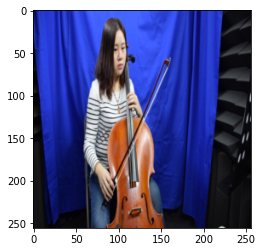

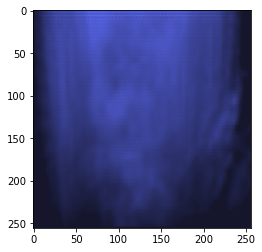

In [65]:
dset = SubURMP(Dataset_Path, True, imgtransform)
image_temp, lms_temp, label_temp = dset[1900]

model.eval()
output, mean, std = model(lms_temp.unsqueeze(0).to('cuda')) 
output = output.squeeze()
output = output.cpu().detach()
plt.figure()
plt.imshow(image_temp.permute(1, 2, 0))
'''
plt.figure()
plt.imshow(output.permute(1, 2, 0)) 
'''
output = output.permute(1, 2, 0).numpy()
output = output/np.amax(output)
output = np.clip(output, 0, 1) 
plt.figure()
plt.imshow((output * 255).astype(np.uint8))

In [71]:
torch.save(model.state_dict(), os.path.join(os.getcwd(),'1130.pth'))